In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 351ms/step - loss: 195.6115 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 194.9002 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 193.7610 - mae: 194.0106
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 191.7773 - mae: 192.4087
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 189.9133 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 35ms/step - loss: 188.0889 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 39ms/step - loss: 185.2864 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 35ms/step - loss: 182.3494 - mae: 183.0458
Epoch 9/100
8/8 [==============================] - 0s 35ms/step - loss: 179.0416 - mae: 179.8092
Epoch 10/100
8/8 [==============================] - 0s 35ms/step - loss: 175.7152 - mae: 176.0968
Epoch 11/100
8/8 [==========

8/8 [==============================] - 0s 35ms/step - loss: 14.0502 - mae: 14.7458
Epoch 88/100
8/8 [==============================] - 0s 33ms/step - loss: 41.1572 - mae: 42.6588
Epoch 89/100
8/8 [==============================] - 0s 34ms/step - loss: 34.0032 - mae: 34.8824
Epoch 90/100
8/8 [==============================] - 0s 36ms/step - loss: 27.5793 - mae: 27.9572
Epoch 91/100
8/8 [==============================] - 0s 35ms/step - loss: 36.4897 - mae: 37.1401
Epoch 92/100
8/8 [==============================] - 0s 35ms/step - loss: 37.6705 - mae: 38.3015
Epoch 93/100
8/8 [==============================] - 0s 34ms/step - loss: 41.8360 - mae: 42.6780
Epoch 94/100
8/8 [==============================] - 0s 35ms/step - loss: 46.6593 - mae: 46.9512
Epoch 95/100
8/8 [==============================] - 0s 34ms/step - loss: 48.1580 - mae: 49.2858
Epoch 96/100
8/8 [==============================] - 0s 36ms/step - loss: 60.0511 - mae: 60.6447
Epoch 97/100
8/8 [==============================] - 0

[1e-08, 0.0001, 0, 30]

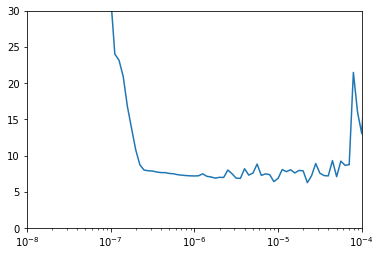

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 239ms/step - loss: 81.1158 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 0s 36ms/step - loss: 23.6082 - mae: 24.3854
Epoch 3/400
8/8 [==============================] - 0s 37ms/step - loss: 18.2200 - mae: 18.7076
Epoch 4/400
8/8 [==============================] - 0s 34ms/step - loss: 14.1506 - mae: 14.6786
Epoch 5/400
8/8 [==============================] - 0s 35ms/step - loss: 10.7218 - mae: 11.2670
Epoch 6/400
8/8 [==============================] - 0s 36ms/step - loss: 12.3048 - mae: 12.4813
Epoch 7/400
8/8 [==============================] - 0s 34ms/step - loss: 12.8882 - mae: 13.4448
Epoch 8/400
8/8 [==============================] - 0s 35ms/step - loss: 12.0483 - mae: 12.6828
Epoch 9/400
8/8 [==============================] - 0s 35ms/step - loss: 9.3639 - mae: 9.8819
Epoch 10/400
8/8 [==============================] - 0s 34ms/step - loss: 15.5118 - mae: 15.9879
Epoch 11/400
8/8 [==============================] 

8/8 [==============================] - 0s 33ms/step - loss: 8.2205 - mae: 8.7544
Epoch 88/400
8/8 [==============================] - 0s 34ms/step - loss: 7.2910 - mae: 7.8314
Epoch 89/400
8/8 [==============================] - 0s 34ms/step - loss: 6.0126 - mae: 6.5333
Epoch 90/400
8/8 [==============================] - 0s 35ms/step - loss: 4.6000 - mae: 5.0807
Epoch 91/400
8/8 [==============================] - 0s 34ms/step - loss: 4.6429 - mae: 5.1015
Epoch 92/400
8/8 [==============================] - 0s 39ms/step - loss: 5.8672 - mae: 6.2420
Epoch 93/400
8/8 [==============================] - 0s 34ms/step - loss: 6.1073 - mae: 6.6354
Epoch 94/400
8/8 [==============================] - 0s 33ms/step - loss: 4.9963 - mae: 5.4981
Epoch 95/400
8/8 [==============================] - 0s 35ms/step - loss: 5.1638 - mae: 5.6586
Epoch 96/400
8/8 [==============================] - 0s 35ms/step - loss: 4.6944 - mae: 5.1996
Epoch 97/400
8/8 [==============================] - 0s 38ms/step - loss: 

8/8 [==============================] - 0s 39ms/step - loss: 4.7767 - mae: 5.2423
Epoch 174/400
8/8 [==============================] - 0s 49ms/step - loss: 5.3982 - mae: 5.8322
Epoch 175/400
8/8 [==============================] - 0s 37ms/step - loss: 5.6943 - mae: 6.2191
Epoch 176/400
8/8 [==============================] - 0s 39ms/step - loss: 4.9235 - mae: 5.3727
Epoch 177/400
8/8 [==============================] - 0s 40ms/step - loss: 4.9641 - mae: 5.3862
Epoch 178/400
8/8 [==============================] - 0s 40ms/step - loss: 4.5870 - mae: 5.1108
Epoch 179/400
8/8 [==============================] - 0s 37ms/step - loss: 4.6126 - mae: 5.0934
Epoch 180/400
8/8 [==============================] - 0s 36ms/step - loss: 5.3104 - mae: 5.8129
Epoch 181/400
8/8 [==============================] - 0s 38ms/step - loss: 4.6751 - mae: 5.2041
Epoch 182/400
8/8 [==============================] - 0s 41ms/step - loss: 4.2919 - mae: 4.7555
Epoch 183/400
8/8 [==============================] - 0s 37ms/ste

8/8 [==============================] - 0s 41ms/step - loss: 5.0326 - mae: 5.5165
Epoch 260/400
8/8 [==============================] - 0s 38ms/step - loss: 4.3276 - mae: 4.7804
Epoch 261/400
8/8 [==============================] - 0s 38ms/step - loss: 4.9668 - mae: 5.4595
Epoch 262/400
8/8 [==============================] - 0s 38ms/step - loss: 6.9560 - mae: 7.4283
Epoch 263/400
8/8 [==============================] - 0s 41ms/step - loss: 6.3060 - mae: 6.8580
Epoch 264/400
8/8 [==============================] - 0s 44ms/step - loss: 5.1656 - mae: 5.6708
Epoch 265/400
8/8 [==============================] - 0s 40ms/step - loss: 4.6592 - mae: 5.1523
Epoch 266/400
8/8 [==============================] - 0s 36ms/step - loss: 4.3737 - mae: 4.8389
Epoch 267/400
8/8 [==============================] - 0s 35ms/step - loss: 4.3304 - mae: 4.7828
Epoch 268/400
8/8 [==============================] - 0s 39ms/step - loss: 4.4179 - mae: 4.9253
Epoch 269/400
8/8 [==============================] - 0s 41ms/ste

8/8 [==============================] - 0s 38ms/step - loss: 4.8837 - mae: 5.3749
Epoch 346/400
8/8 [==============================] - 0s 37ms/step - loss: 4.6039 - mae: 5.0734
Epoch 347/400
8/8 [==============================] - 0s 34ms/step - loss: 4.2581 - mae: 4.7134
Epoch 348/400
8/8 [==============================] - 0s 36ms/step - loss: 4.6078 - mae: 5.0908
Epoch 349/400
8/8 [==============================] - 0s 36ms/step - loss: 5.0626 - mae: 5.5352
Epoch 350/400
8/8 [==============================] - 0s 37ms/step - loss: 5.3528 - mae: 5.8286
Epoch 351/400
8/8 [==============================] - 0s 36ms/step - loss: 4.5880 - mae: 5.0606
Epoch 352/400
8/8 [==============================] - 0s 36ms/step - loss: 4.3828 - mae: 4.8637
Epoch 353/400
8/8 [==============================] - 0s 36ms/step - loss: 4.3007 - mae: 4.7812
Epoch 354/400
8/8 [==============================] - 0s 37ms/step - loss: 4.2296 - mae: 4.6723
Epoch 355/400
8/8 [==============================] - 0s 36ms/ste

In [0]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()